# Predictive analysis

Because our target is units sold, which is a numeric continious value, A regression model would be apropriate to use

We start by loading up the libraries needed

In [278]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf  
from sklearn.feature_selection import SelectKBest, f_regression

Load the dataset

In [ ]:
df = pd.read_csv(R'Ecommerce_Sales_Dataset.csv')
print(df.head())

         Date Product_Category   Price  Discount Customer_Segment  \
0  01/01/2023           Sports  932.80     35.82       Occasional   
1  02/01/2023             Toys  569.48      3.60          Premium   
2  03/01/2023       Home Decor  699.68      3.56          Premium   
3  04/01/2023             Toys  923.27      0.61          Premium   
4  05/01/2023             Toys  710.17     47.83          Premium   

   Marketing_Spend  Units_Sold  
0          6780.38          32  
1          6807.56          16  
2          3793.91          27  
3          9422.75          29  
4          1756.83          17  


Data pre-processing by chaing date to datetime while isolating the target column and giving it an index of the dates

In [280]:
Target = df['Units_Sold']
Target.index=pd.to_datetime(df['Date'], dayfirst=True)
Target

Date
2023-01-01    32
2023-01-02    16
2023-01-03    27
2023-01-04    29
2023-01-05    17
              ..
2025-09-22    34
2025-09-23    21
2025-09-24    19
2025-09-25    26
2025-09-26    39
Name: Units_Sold, Length: 1000, dtype: int64

Ploting to visualize the data

<Axes: xlabel='Date'>

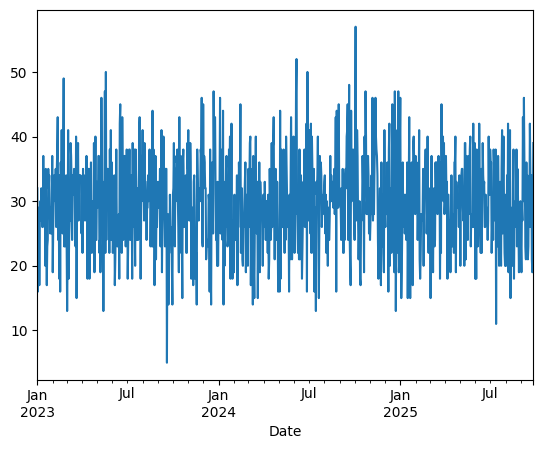

In [281]:
Target.plot()

# Start to working on an Exponential Moving Average Model

In [282]:
ema_50 = Target.ewm(span=50,adjust=False).mean()

Plotting the EMA with the data 

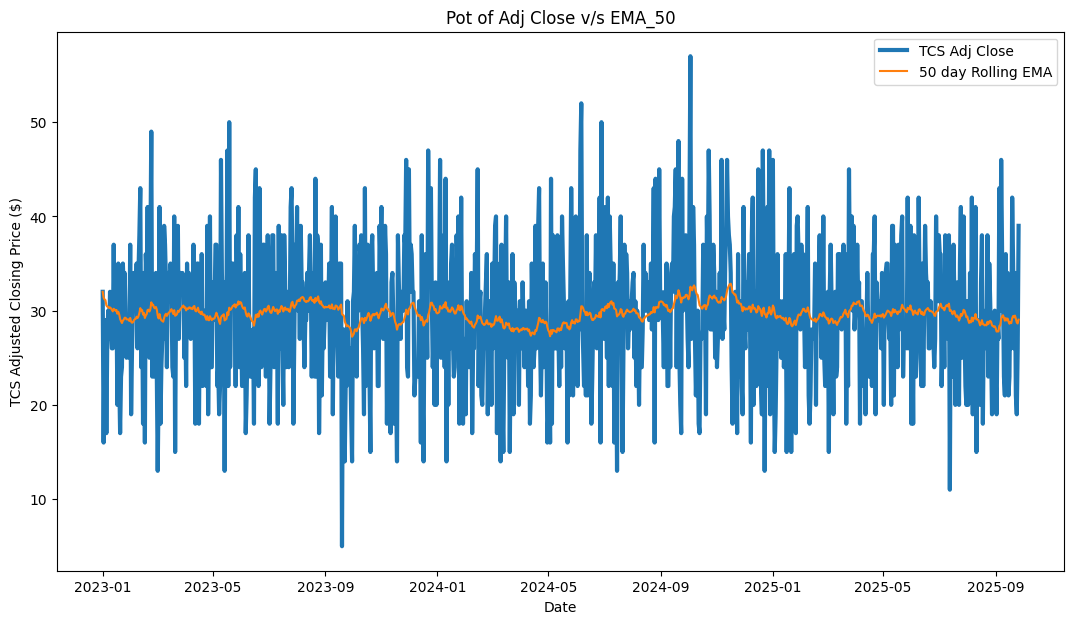

In [283]:
plt.figure(figsize = (13,7))
plt.plot(Target,label='TCS Adj Close',linewidth=3)
plt.plot(ema_50,label='50 day Rolling EMA',linewidth=1.5)
plt.xlabel('Date')
plt.ylabel('TCS Adjusted Closing Price ($)')
plt.title('Pot of Adj Close v/s EMA_50')
plt.legend()

Metrics to show accuracy 

In [284]:

Target = Target.sort_index()
split = int(len(Target) * 0.80)
y_test = Target.iloc[split:]
ema_2   = Target.ewm(span=50,adjust= False).mean()
y_pred  = ema_2.shift(1).iloc[split:]   
mask    = y_pred.notna()
y_true  = y_test[mask]
y_pred  = y_pred[mask]


In [285]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

MSE: 45.63135110307523
RMSE: 6.755098156435274
R²: -0.030882083008632266
MAE: 5.557115456985389


# Linear regression

Data pre-processing and feature selection

In [286]:
df2 = df.copy()
df2['Date']   = pd.to_datetime(df['Date'], dayfirst=True)      
df2['Year']   = df2['Date'].dt.year
df2['Month']  = df2['Date'].dt.month
df2['Day']    = df2['Date'].dt.day
df2.drop(columns=['Date'], inplace=True)


Encoding the categorical columns

In [287]:
cat_cols = df2.select_dtypes(include='object').columns
df2 = pd.get_dummies(df2, columns=cat_cols, drop_first=True)

Splitting the target from the other columns

In [288]:
y = df2['Units_Sold']
X = df2.drop(columns=['Units_Sold'])

Splitting the data into training and testing 

In [289]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()

Scaling the features so the model wont get easily affected by different margins of numbers

In [290]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

Using sequential feature selection for feature selection

In [291]:
base_model = LinearRegression()
sfs = SequentialFeatureSelector(
        estimator=base_model,
        n_features_to_select='auto',   
        direction='forward',
        cv=5,
        scoring='neg_mean_absolute_error'
     )
sfs.fit(X_train, y_train)

,estimator,LinearRegression()
,n_features_to_select,'auto'
,tol,None
,direction,'forward'
,scoring,'neg_mean_absolute_error'
,cv,5
,n_jobs,None
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None


Fitting the sequential feature selected features into the final model 

In [292]:
X_train_sel = sfs.transform(X_train)
X_test_sel  = sfs.transform(X_test)
final_model = LinearRegression().fit(X_train_sel, y_train)
y_pred      = final_model.predict(X_test_sel)

Metrics to measure the outcome

In [293]:
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

MSE: 56.20715950846788
RMSE: 7.497143423229136
R²: -0.03926102622215044
MAE: 5.953852515536609


Graph

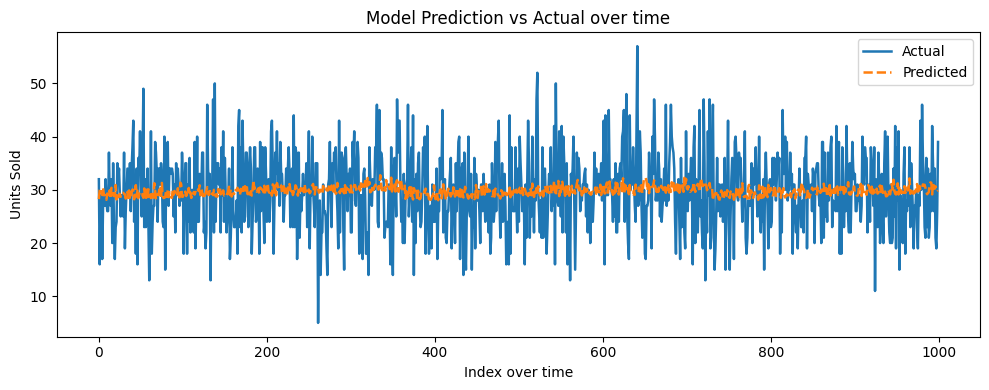

In [294]:
X_full   = df2.drop(columns=['Units_Sold'])
X_full   = scaler.transform(X_full)     
X_full   = sfs.transform(X_full)        
y_pred_f = final_model.predict(X_full)

plt.figure(figsize=(10,4))
plt.plot(df2.index, df['Units_Sold'], label='Actual', lw=1.8)
plt.plot(df2.index, y_pred_f,  label='Predicted', lw=1.8, ls='--')
plt.xlabel('Index over time')      
plt.ylabel('Units Sold')
plt.title('Model Prediction vs Actual over time')
plt.legend()
plt.tight_layout()
plt.show()

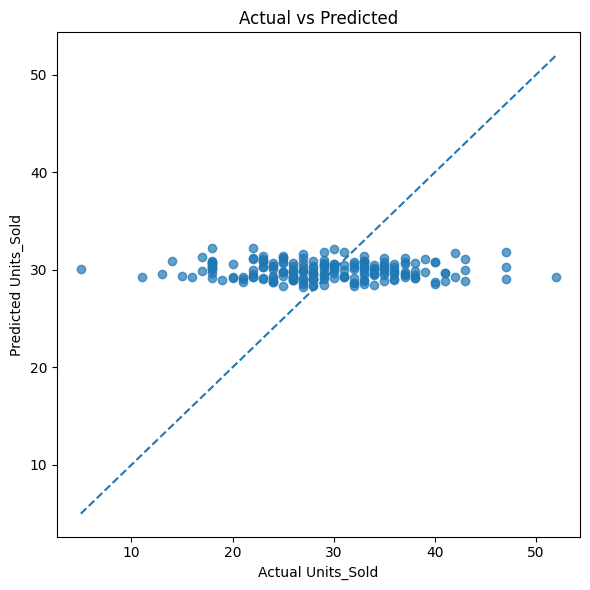

In [295]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--')                       # 45-degree reference
plt.xlabel('Actual Units_Sold')
plt.ylabel('Predicted Units_Sold')
plt.title('Actual vs Predicted')
plt.tight_layout()
plt.show()

# LTSM

Data pre-processing

In [296]:
df3 = df.copy()
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df['Date'] = df['Date'].dt.month

Selecting all numerical features and seperating the target

In [297]:
features = ['Date', 'Price', 'Units_Sold','Discount','Marketing_Spend']
target = 'Units_Sold'

X = df[features]
y = df[target]

Scaling the features

In [298]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

Splitting into train and test

In [299]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state=42)
y_train = np.array(y_train)
y_test = np.array(y_test)

Using selectKbest to choose the 3 best features to use

In [300]:
selector = SelectKBest(score_func=f_regression, k=3)
selector.fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected  = selector.transform(X_test)

Building the model

In [301]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
  tf.keras.layers.Dense(32, activation='relu'), 
  tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

c:\USERS\HAMRO\APPDATA\LOCAL\PROGRAMS\PYTHON\PYTHON312\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training the model

In [302]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=5)

Epoch 1/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 783.9785 - mae: 26.6984 - val_loss: 53.9399 - val_mae: 5.7440
Epoch 2/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 54.7751 - mae: 5.9526 - val_loss: 43.1129 - val_mae: 5.1325
Epoch 3/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 38.0771 - mae: 5.0577 - val_loss: 28.9264 - val_mae: 4.1977
Epoch 4/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 24.4730 - mae: 3.9717 - val_loss: 16.5800 - val_mae: 3.1870
Epoch 5/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3109 - mae: 2.8483 - val_loss: 7.0230 - val_mae: 2.0749


Evaluations of the model

In [303]:
loss, mae = model.evaluate(X_test, y_test)
print(f"Mean Absolute Error on Test Data: {mae}")
predictions = model.predict(X_test)
r2 = r2_score(y_test, predictions)
print(f"R-squared Score on Test Data: {r2}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.1161 - mae: 2.0607 
Mean Absolute Error on Test Data: 2.074899673461914
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
R-squared Score on Test Data: 0.870145320892334


Comparing the predicted with the actual

In [304]:
predictions_flat = predictions.flatten()
comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': predictions_flat
})
comparison_df

,Actual,Predicted
0,47,40.565765
1,26,26.743282
2,25,26.134251
3,33,31.962660
4,31,29.798550
...,...,...
195,34,32.047359
196,24,26.412411
197,18,22.530128
198,32,31.479275


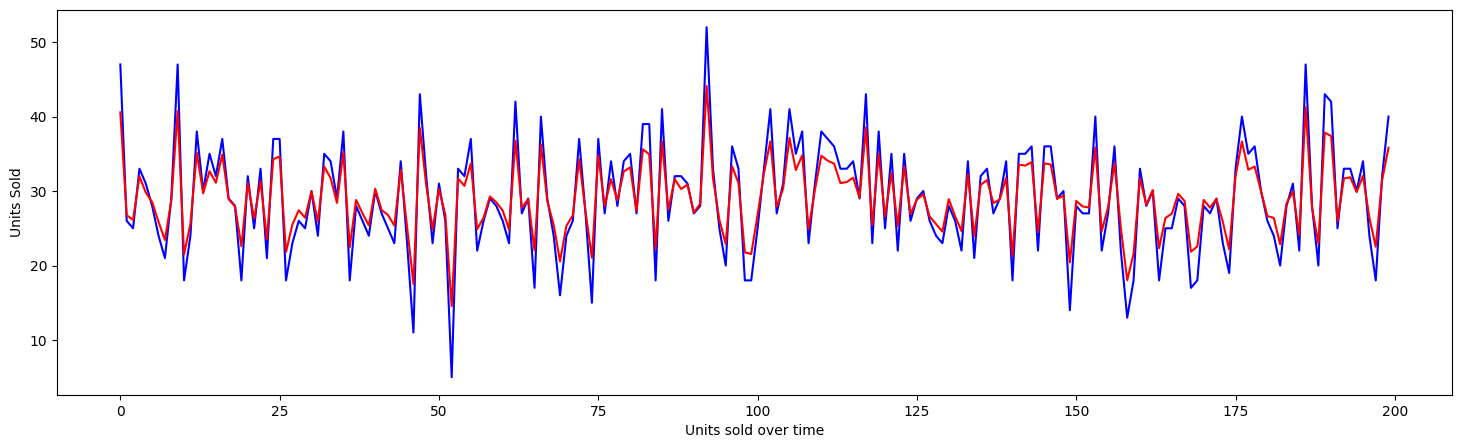

In [320]:
plt.figure(figsize=(18,5))
plt.plot( y_test, label='Actual Units Sold', color='blue')
plt.plot(predictions_flat, label='Predicted Units Sold', color='red')
plt.xlabel('Units sold over time')
plt.ylabel('Units Sold')
plt.show() 